#EDA with solar data

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
from __future__ import division

##Sensor data from NREL

###Hawaii:

In [34]:
df = pd.read_csv('data/sensor20150701.txt')
df.head()

,DATE (MM/DD/YYYY),HOUR-HST,Avg Global Horizontal [W/m^2],Avg Global PAR [umol/s/m^2],Avg Air Temperature [deg C],Avg Dew Point Temp [deg C],Avg Rel Humidity [%],Avg Station Pressure [mBar],Avg CR1000 Temp [deg C],Avg CR1000 Battery [VDC]
0,7/1/2015,1,-1.5214,-0.6173,26.709,22.5735,78.0075,1012.2700,26.7250,11.93
1,7/1/2015,2,-0.9041,-0.5930,26.721,22.4702,77.4735,1011.5845,26.8567,11.93
2,7/1/2015,3,-1.0224,-0.5679,26.610,22.3082,77.2130,1011.0637,26.9235,11.93
3,7/1/2015,4,-0.7767,-0.4894,26.625,22.2568,76.9027,1010.8700,26.9622,11.93
4,7/1/2015,5,-0.9165,-0.6244,26.337,21.9572,76.8125,1010.7870,26.9322,11.93


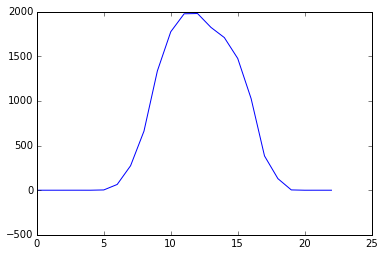

In [35]:
plt.plot(df['Avg Global PAR [umol/s/m^2]'].values)

###Colorado:

In [38]:
col_0701_df = pd.read_csv('data/colorado20150701.txt')
def to_str(x):
    if x < 10:
        return '0' + x.astype(str)
    else:
        return x.astype(str)
        
col_0701_df['datetime'] = pd.to_datetime(col_0701_df['DATE (MM/DD/YYYY)']+' '+col_0701_df['HOUR-MST'].map(to_str))
intensities = np.insert(col_0701_df['Avg Global PSP (vent/cor) [W/m^2]'].values,0,0)

In [41]:
spectrometer = col_0701_df[col_0701_df.index==10].values.reshape(43,)[7:12]

In [42]:
wavelengths = np.array([400, 500, 675, 940, 1020])

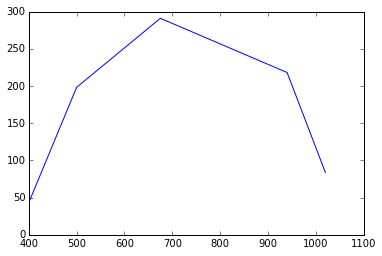

In [43]:
plt.plot(wavelengths,spectrometer)

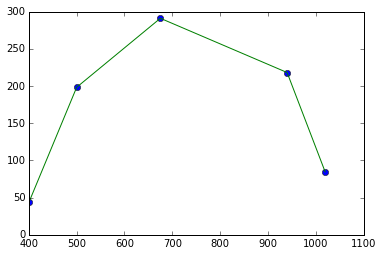

In [44]:
from scipy import interpolate

x = wavelengths
y = spectrometer

f = interpolate.interp1d(x, y)
wav_new = np.arange(400,1020, 0.5) #300 nm to 1180 nm with 0.5 nm spacing
spec_new = f(wav_new)   #recreate AM1.5 with 0.5 nm spacing

plt.plot(x, y, 'o', wav_new, spec_new, '-')
plt.show()

In [45]:
sum(wav_new*spec_new)*.5/1240/100

780.22615203649048

##Web scraping for pvoutput.org

In [46]:
import mechanize
import cookielib
import os
PVOUTPUT_USERNAME = os.environ['PVOUTPUT_USERNAME']
PVOUTPUT_PASSWORD = os.environ['PVOUTPUT_PASSWORD']
PVOUTPUT_API = os.environ['PVOUTPUT_API']

#web scraping
cj = cookielib.CookieJar() #saves the cookie?
br = mechanize.Browser() #instansiates a browser
br.set_handle_robots(False) #I am not a robot...
br.set_cookiejar(cj) #use cookie?
br.open("http://pvoutput.org/") #open login page
br.select_form(nr=0) #select login form
br.form['login'] = PVOUTPUT_USERNAME #login using saved env vars
br.form['password'] = PVOUTPUT_PASSWORD #login using saved env vars
br.submit() #press enter
#print br.response().read() #see if it worked
br.open("http://pvoutput.org/intraday.jsp?id=5446&sid=5473&dt=20150701") #open desired page
html = br.response().read() #read desired page
df_html = pd.read_html(html)[0]

#cleaning the data
df_html.columns = pd.MultiIndex.from_arrays(df_html[df_html.index==1].values)
df_html.drop(df_html.index[[0,1]],inplace=True)
df_html['Power'] = df_html['Power'].str.replace(',','')
df_html['Power'] = df_html['Power'].map(lambda x: x.rstrip('W'))

def make_a_no(x):                  
    try:
        return int(x)
    except:
        x = 0 
        return x
    
df_html['Power'] = df_html['Power'].map(make_a_no)
df_html['datetime'] = pd.to_datetime(df_html['Date'] + ' ' + df_html['Time'], unit='h')
df_html.set_index(['datetime'],inplace=True)
df_html.head()

,Date,Time,Energy,Efficiency,Power,Average,Normalised,Temperature,Voltage,Energy Used,Power Used,nan
datetime,,,,,,,,,,,,
2015-07-01 23:55:00,2015-07-01,23:55,61.260kWh,4.317kWh/kW,0,0W,0.000kW/kW,-,-,66.801kWh,"1,921W",NaN
2015-07-01 23:50:00,2015-07-01,23:50,61.260kWh,4.317kWh/kW,0,0W,0.000kW/kW,-,-,66.641kWh,"2,215W",NaN
2015-07-01 23:45:00,2015-07-01,23:45,61.260kWh,4.317kWh/kW,0,0W,0.000kW/kW,-,-,66.456kWh,"2,230W",NaN
2015-07-01 23:40:00,2015-07-01,23:40,61.260kWh,4.317kWh/kW,0,0W,0.000kW/kW,-,-,66.271kWh,"2,237W",NaN
2015-07-01 23:35:00,2015-07-01,23:35,61.260kWh,4.317kWh/kW,0,0W,0.000kW/kW,-,-,66.084kWh,"2,230W",NaN


##Making a simple linear model

In [47]:
powers = df_html.resample('H', how='mean')['Power'].values

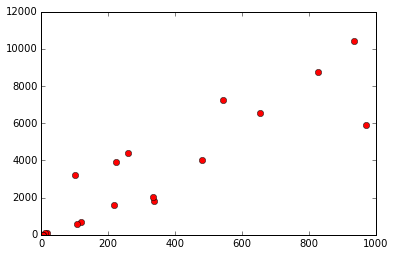

In [48]:
plt.plot(intensities,powers,'ro') #output powers vs. intensities

In [49]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(powers,intensities)
res = mod.fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     231.0
Date:                Tue, 04 Aug 2015   Prob (F-statistic):           1.74e-13
Time:                        20:44:09   Log-Likelihood:                -204.38
No. Observations:                  24   AIC:                             410.8
Df Residuals:                      23   BIC:                             411.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             9.5328      0.627     15.199      0.0

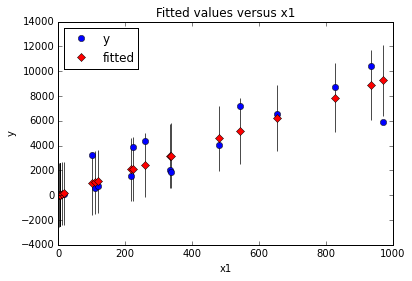

In [50]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res, 0, ax=ax)

##Another day: the next day (July 2nd)

In [51]:
col_0702_df = pd.read_csv('data/colorado20150702.txt')
def to_str(x):
    if x < 10:
        return '0' + x.astype(str)
    else:
        return x.astype(str)
        
col_0702_df['datetime'] = pd.to_datetime(col_0702_df['DATE (MM/DD/YYYY)']+' '+col_0702_df['HOUR-MST'].map(to_str))
intensities = np.insert(col_0702_df['Avg Global PSP (vent/cor) [W/m^2]'].values,0,0)

### copy from above

In [52]:
import mechanize
import cookielib
import os
PVOUTPUT_USERNAME = os.environ['PVOUTPUT_USERNAME']
PVOUTPUT_PASSWORD = os.environ['PVOUTPUT_PASSWORD']
PVOUTPUT_API = os.environ['PVOUTPUT_API']

#web scraping
cj = cookielib.CookieJar() #saves the cookie?
br = mechanize.Browser() #instansiates a browser
br.set_handle_robots(False) #I am not a robot...
br.set_cookiejar(cj) #use cookie?
br.open("http://pvoutput.org/") #open login page
br.select_form(nr=0) #select login form
br.form['login'] = PVOUTPUT_USERNAME #login using saved env vars
br.form['password'] = PVOUTPUT_PASSWORD #login using saved env vars
br.submit() #press enter
#print br.response().read() #see if it worked
br.open("http://pvoutput.org/intraday.jsp?id=5446&sid=5473&dt=20150702") #open desired page
html = br.response().read() #read desired page
df_html = pd.read_html(html)[0]

#cleaning the data
df_html.columns = pd.MultiIndex.from_arrays(df_html[df_html.index==1].values)
df_html.drop(df_html.index[[0,1]],inplace=True)
df_html['Power'] = df_html['Power'].str.replace(',','')
df_html['Power'] = df_html['Power'].map(lambda x: x.rstrip('W'))

def make_a_no(x):                  
    try:
        return int(x)
    except:
        x = 0 
        return x
    
df_html['Power'] = df_html['Power'].map(make_a_no)
df_html['datetime'] = pd.to_datetime(df_html['Date'] + ' ' + df_html['Time'], unit='h')
df_html.set_index(['datetime'],inplace=True)
df_html.head()

,Date,Time,Energy,Efficiency,Power,Average,Normalised,Temperature,Voltage,Energy Used,Power Used,nan
datetime,,,,,,,,,,,,
2015-07-02 23:55:00,2015-07-02,23:55,74.866kWh,5.276kWh/kW,0,0W,0.000kW/kW,-,-,53.868kWh,"1,789W",NaN
2015-07-02 23:50:00,2015-07-02,23:50,74.866kWh,5.276kWh/kW,0,0W,0.000kW/kW,-,-,53.719kWh,"1,881W",NaN
2015-07-02 23:45:00,2015-07-02,23:45,74.866kWh,5.276kWh/kW,0,0W,0.000kW/kW,-,-,53.562kWh,"2,032W",NaN
2015-07-02 23:40:00,2015-07-02,23:40,74.866kWh,5.276kWh/kW,0,0W,0.000kW/kW,-,-,53.393kWh,"2,031W",NaN
2015-07-02 23:35:00,2015-07-02,23:35,74.866kWh,5.276kWh/kW,0,0W,0.000kW/kW,-,-,53.224kWh,"2,057W",NaN


###use yesterdays model to predict today

In [53]:
powers = df_html.resample('H', how='mean')['Power'].values

In [54]:
powers_pred = res.predict(intensities)

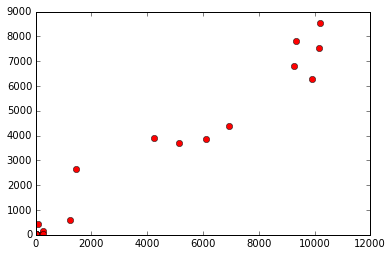

In [55]:
plt.plot(powers,powers_pred, 'ro')

In [56]:
mod2 = sm.OLS(powers_pred,powers)
res2 = mod.fit()
print res2.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     231.0
Date:                Tue, 04 Aug 2015   Prob (F-statistic):           1.74e-13
Time:                        20:44:17   Log-Likelihood:                -204.38
No. Observations:                  24   AIC:                             410.8
Df Residuals:                      23   BIC:                             411.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             9.5328      0.627     15.199      0.0

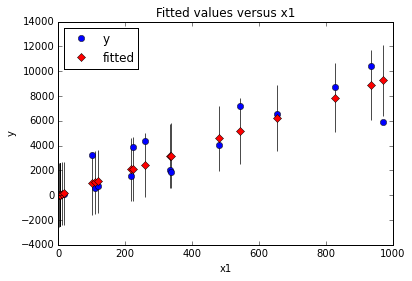

In [57]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res2, 0, ax=ax)

##Now a satellite? (or what are we gunna do?)

In [114]:
import netCDF4

In [125]:
from netCDF4 import Dataset
rootgrp = Dataset("data/satellite/colorado/20150701/goes15.2015.182.123017.BAND_01.nc", "a", format="NETCDF4")

In [126]:
rootgrp.data_model #netcdf3_classic, not netcdf4

'NETCDF3_CLASSIC'

In [127]:
for i in rootgrp.variables: #list of variables
    print i

version
sensorID
imageDate
imageTime
startLine
startElem
time
dataWidth
lineRes
elemRes
prefixSize
crDate
crTime
bands
auditTrail
data
lat
lon


In [128]:
rootgrp.variables['lat'][0][0] #verify that one latitude is where we expect

41.000637

In [129]:
lons = rootgrp.variables['lon'][:]
lats = rootgrp.variables['lat'][:]
data = rootgrp.variables['data'][:] #data is sensor data

In [130]:
rootgrp.close()

In [131]:
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [146]:
# Get some parameters for the Stereographic Projection
m = Basemap(width=800000,height=800000,
            resolution='l',projection='stere',\
            lat_ts=40,lat_0=39.5,lon_0=-104.5)

xi, yi = m(lons, lats) #map onton x and y for plotting

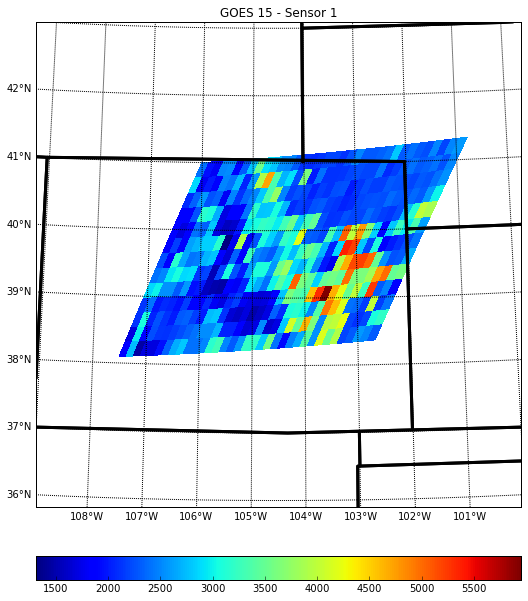

In [147]:
plt.figure(figsize=(10,10)) # Plot Data
cs = m.pcolor(xi,yi,np.squeeze(data)) #data is 1 x 14 x 36, squeeze makes it 14 x 36

m.drawparallels(np.arange(-80., 81., 1.), labels=[1,0,0,0], fontsize=10) # Add Grid Lines
m.drawmeridians(np.arange(-180., 181., 1.), labels=[0,0,0,1], fontsize=10) # Add Grid Lines
m.drawstates(linewidth=3) # Add state boundaries

cbar = m.colorbar(cs, location='bottom', pad="10%") # Add Colorbar
plt.title('GOES 15 - Sensor 1') # Add Title
plt.show()

##Try WunderGround API - (it doesn't have historical data)

In [1]:
import os
WUNDERGROUND_API = os.environ['WUNDERGROUND_API']

##Automate GOES satellite downloads

In [4]:
from noaaclass import noaaclass
import os

In [5]:
username = os.environ['NOAA_USERNAME']
password = os.environ['NOAA_PASSWORD']
noaa = noaaclass.connect(username, password)

In [6]:
print noaa.subscribe.products()

['gvar_img']


In [22]:
from noaaclass import noaaclass
noaa = noaaclass.connect(username, password)
data = noaa.subscribe.gvar_img.get()

In [26]:
data = noaa.request.gvar_img.get(async=True, hours = 6, append_files=True)

In [31]:
data[0]['files']

{'ftp': ['ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.021520.meta',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.021520.BAND_03.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.021520.BAND_04.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.021520.BAND_01.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.021520.BAND_02.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.021520.BAND_06.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.024520.BAND_01.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.024520.meta',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.024520.BAND_02.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.024520.BAND_06.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.024520.BAND_03.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.024520.BAND_04.nc

In [16]:
from datetime import datetime
data3 = [
    {
        'id': '+',
        'enabled': True,
        'name': '[auto] sample1',
        'north': 41.00,
        'south': 38.00,
        'west': -106.00,
        'east': -103.00,
        'coverage': ['NH'],
        'schedule': ['R'],
        'satellite': ['G15'],
        'channel': [1, 2, 3, 4, 5, 6],
        'format': 'NetCDF',
        'start': datetime(2014, 7, 2, 0, 0, 0),
        'end': datetime(2014, 7, 2, 23, 59, 59)
    }
]

In [17]:
from noaaclass import noaaclass
noaa = noaaclass.connect(username, password)

In [18]:
data3 = noaa.request.gvar_img.set(data2, async=True)

In [19]:
data3

[{'channel': [1],
  'datetime': datetime.datetime(2015, 8, 5, 2, 55, 33),
  'east': -103.0,
  'files': {'ftp': [], 'http': []},
  'format': u'NetCDF',
  'id': u'1982768383',
  'last_activity': datetime.datetime(2015, 8, 5, 2, 59, 6),
  'north': 41.0,
  'old': False,
  'size': 46740,
  'south': 38.0,
  'status': u'in progress',
  'west': -106.0}]